In [27]:
import pandas as pd
import numpy as np

from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
import xgboost

import shap
shap.initjs()

import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False


import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('Hair.csv')

scaler = StandardScaler()

In [3]:
data.columns

Index(['Id', 'Genetics', 'Hormonal Changes', 'Medical Conditions',
       'Medications & Treatments', 'Nutritional Deficiencies ', 'Stress',
       'Age', 'Poor Hair Care Habits ', 'Environmental Factors', 'Smoking',
       'Weight Loss ', 'Hair Loss'],
      dtype='object')

In [6]:
new_data = data.drop(['Id'], axis=1)

new_data = new_data.replace('Yes', 1)
new_data = new_data.replace('No', 0)

stress_mapping = {'Low': 1, 'Moderate': 2, 'High': 3}
new_data['Stress'] = new_data['Stress'].replace(stress_mapping)

new_data = pd.get_dummies(new_data,columns=['Medical Conditions','Medications & Treatments','Nutritional Deficiencies '])

new_data.head()

,Genetics,Hormonal Changes,Stress,Age,Poor Hair Care Habits,Environmental Factors,Smoking,Weight Loss,Hair Loss,Medical Conditions_Alopecia Areata,...,Nutritional Deficiencies _Iron deficiency,Nutritional Deficiencies _Magnesium deficiency,Nutritional Deficiencies _No Data,Nutritional Deficiencies _Omega-3 fatty acids,Nutritional Deficiencies _Protein deficiency,Nutritional Deficiencies _Selenium deficiency,Nutritional Deficiencies _Vitamin A Deficiency,Nutritional Deficiencies _Vitamin D Deficiency,Nutritional Deficiencies _Vitamin E deficiency,Nutritional Deficiencies _Zinc Deficiency
0,1,0,2,19,1,1,0,0,0,False,...,False,True,False,False,False,False,False,False,False,False
1,0,0,3,43,1,1,0,0,0,False,...,False,True,False,False,False,False,False,False,False,False
2,0,0,2,26,1,1,0,1,0,False,...,False,False,False,False,True,False,False,False,False,False
3,1,1,2,46,1,1,0,0,0,False,...,False,False,False,False,False,False,False,False,False,False
4,0,0,2,30,0,1,1,0,1,False,...,True,False,False,False,False,False,False,False,False,False


In [7]:
new_data_numeric = new_data.drop(['Medical Conditions_No Data', 'Medications & Treatments_Rogaine', 'Nutritional Deficiencies _Zinc Deficiency'], axis=1).astype(float)

new_data_numeric.fillna(new_data_numeric.mean(), inplace=True)

columns = new_data_numeric.columns.tolist()
columns.remove('Hair Loss')

x = new_data_numeric[columns].assign(const=1)

vif_data = pd.DataFrame()
vif_data['feature'] = x.columns
vif_data['VIF'] = [variance_inflation_factor(x.values, i) for i in range(x.shape[1])]

vif_data.sort_values(by='VIF', ascending=False)

,feature,VIF
38,const,68.240559
8,Medical Conditions_Alopecia Areata,1.856289
31,Nutritional Deficiencies _No Data,1.850255
36,Nutritional Deficiencies _Vitamin D Deficiency,1.808349
9,Medical Conditions_Androgenetic Alopecia,1.801735
13,Medical Conditions_Psoriasis,1.801082
20,Medications & Treatments_Antidepressants,1.794297
17,Medical Conditions_Thyroid Problems,1.781563
35,Nutritional Deficiencies _Vitamin A Deficiency,1.774735
27,Medications & Treatments_Steroids,1.773292


In [20]:
x = new_data.drop('Hair Loss', axis=1)
y = new_data['Hair Loss']

rf_clf = RandomForestClassifier(random_state=15)
rfe_selector = RFE(estimator=rf_clf, n_features_to_select=10, step=1)
rfe_selector.fit(x, y)

selected_features = x.columns[rfe_selector.support_]

print("Selected Features:", selected_features)

Selected Features: Index(['Genetics', 'Hormonal Changes', 'Stress', 'Age',
       'Poor Hair Care Habits ', 'Environmental Factors', 'Smoking',
       'Weight Loss ', 'Medications & Treatments_Antidepressants ',
       'Nutritional Deficiencies _Zinc Deficiency'],
      dtype='object')


In [21]:
x_model=x[['Age','Stress','Hormonal Changes','Smoking','Environmental Factors','Genetics','Poor Hair Care Habits ','Weight Loss ']]

选择的特征如上

In [23]:
x_train, x_test, y_train, y_test = train_test_split(x_model, y, test_size=0.25, random_state=15)

model = xgboost.XGBClassifier(n_estimators=100, max_depth=2, enable_categorical=True)
model.fit(x_train, y_train)
y_pred_rf = model.predict(x_test)

class_report_rf = classification_report(y_test, y_pred_rf)

print(class_report_rf)

              precision    recall  f1-score   support

           0       0.60      0.45      0.52       143
           1       0.45      0.60      0.51       107

    accuracy                           0.52       250
   macro avg       0.53      0.53      0.52       250
weighted avg       0.54      0.52      0.52       250



模型评估如上


逻辑回归模型评分如下:

精确度: 对于类别0，精确度为0.58，对于类别1，精确度为0.47。

召回率: 对于类别0，召回率为0.52，对于类别1，召回率为0.53。

F1得分: 对于类别0，F1得分为0.55，对于类别1，F1得分为0.5。

准确率: 0.53

ROC: 0.51


结果请照着表格修改一下

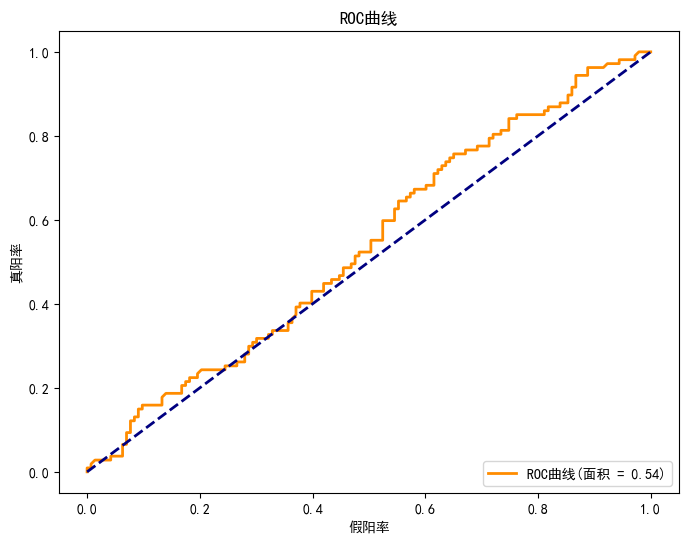

In [12]:
fpr, tpr, _ = roc_curve(y_test, model.predict_proba(x_test)[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC曲线(面积 = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('假阳率')
plt.ylabel('真阳率')
plt.title('ROC曲线')
plt.legend(loc="lower right")
plt.show()


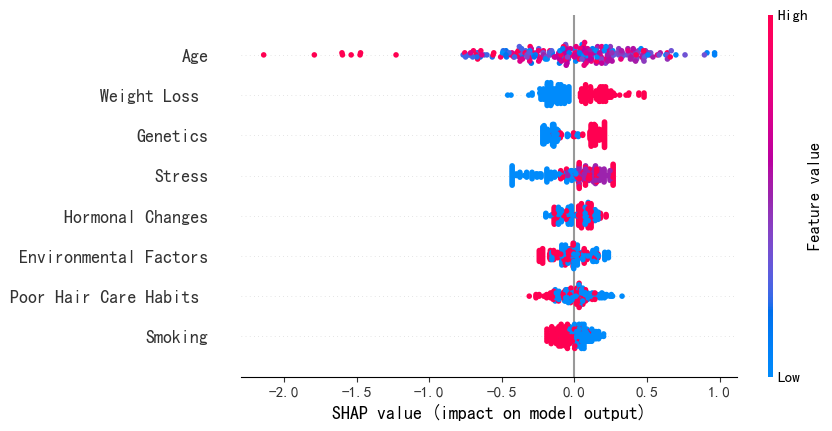

In [28]:
explainer = shap.TreeExplainer(model)
shap_values = explainer(x_test)
shap_interaction = explainer.shap_interaction_values(x_test)
# 特征的重要性
shap.plots.beeswarm(shap_values)

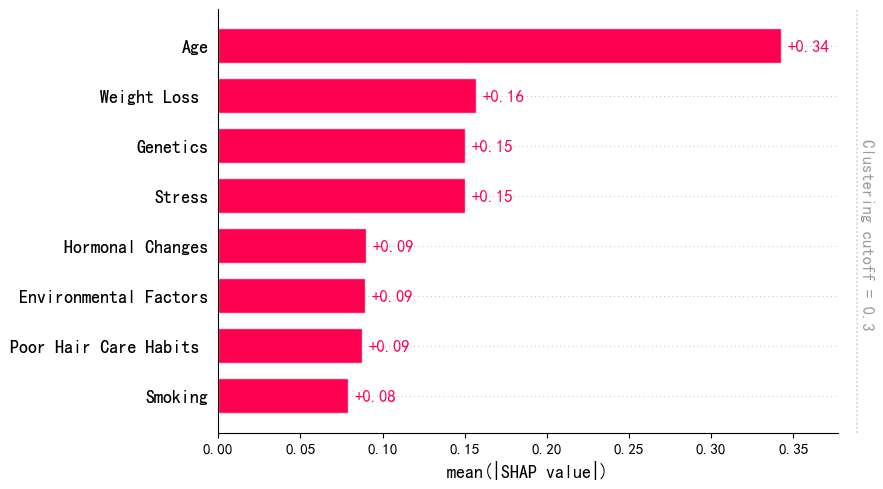

In [27]:
# 聚类
clustering = shap.utils.hclust(x_model, y)

# 结合聚类信息进行展示，聚类结果中距离小于 0.3 的特征会被分在同一组中
shap.plots.bar(shap_values, clustering=clustering, clustering_cutoff=0.3)

In [32]:
from sklearn.cluster import KMeans

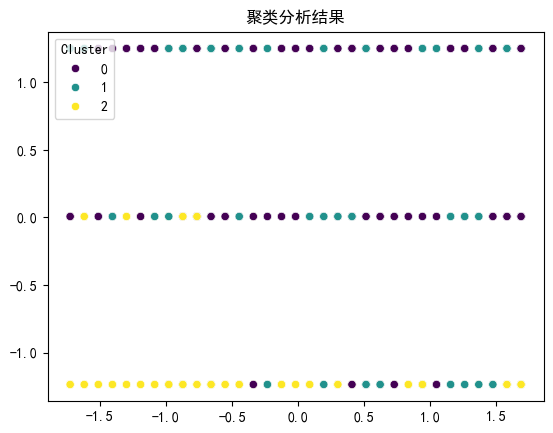

In [33]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(x_model)
kmeans = KMeans(n_clusters=3, random_state=42)
data['Cluster'] = kmeans.fit_predict(X_scaled)
sns.scatterplot(x=X_scaled[:, 0], y=X_scaled[:, 1], hue=data['Cluster'], palette='viridis')
plt.title("\u805a\u7c7b\u5206\u6790\u7ed3\u679c")
plt.show()

In [ ]:
tree_model = DecisionTreeClassifier(random_state=42)
tree_model.fit(X_train, y_train)
plt.figure(figsize=(15, 10))
plot_tree(tree_model, feature_names=X.columns, class_names=['No HairLoss', 'HairLoss'], filled=True)
plt.title("\u51b3\u7b56\u6811")
plt.show()

In [ ]:
X_T

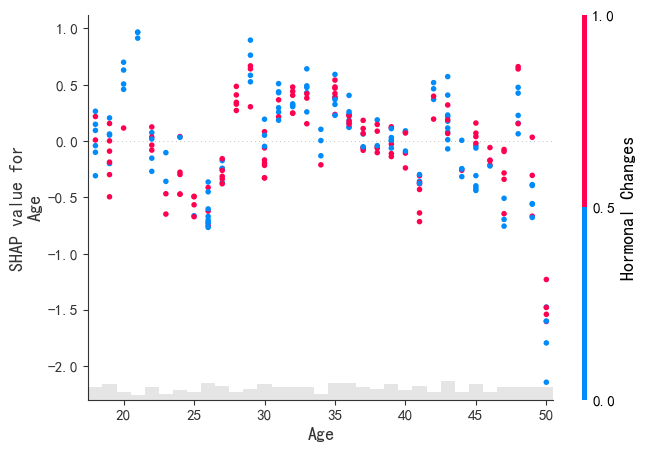

In [28]:
# 使用散点图可视化单个变量 Age 与 SHAP 值之间的关系
# 颜色参数使用 SHAP 值自身作为颜色
shap.plots.scatter(shap_values[:, 'Age'], color=shap_values)

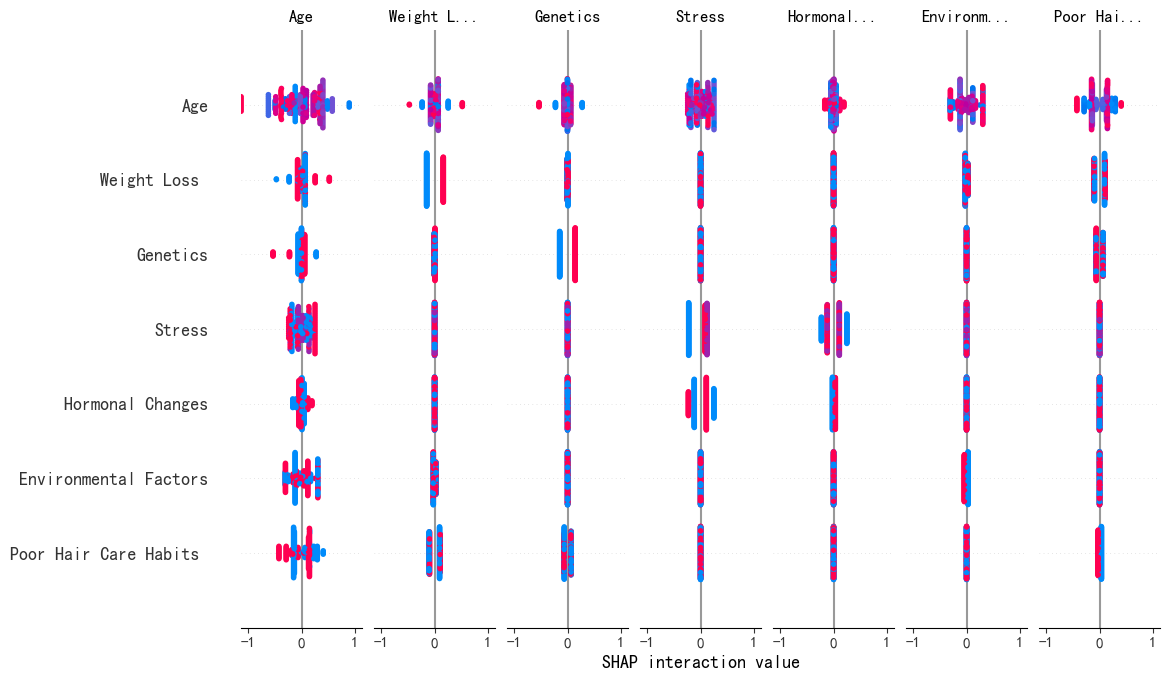

In [16]:
shap.summary_plot(shap_interaction, x_test)

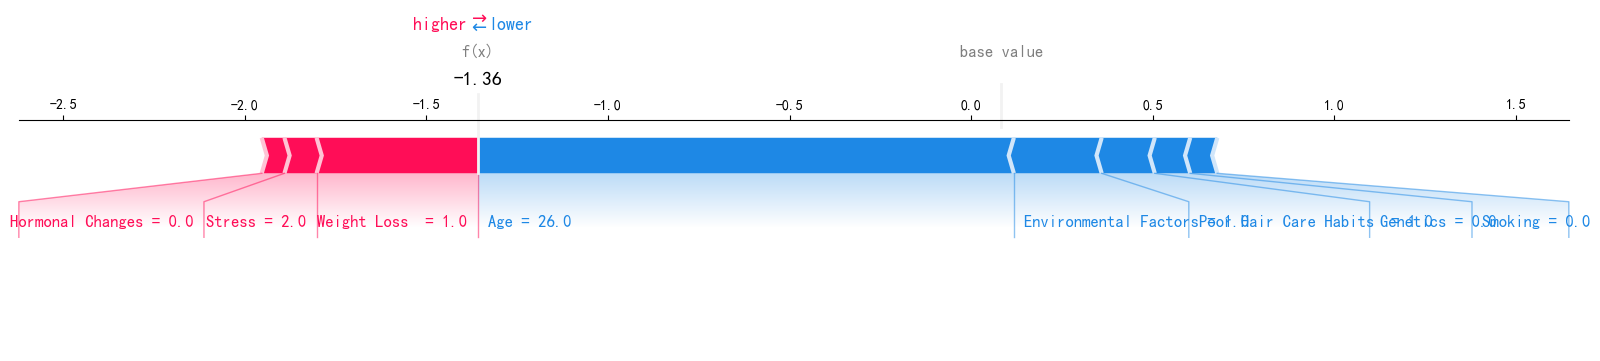

In [17]:
import shap

shap.initjs()

import xgboost

model = xgboost.XGBClassifier(n_estimators=100, max_depth=2, enable_categorical=True)

model.fit(x_train, y_train)

explainer = shap.TreeExplainer(model)

shap_values = explainer.shap_values(x_test)

shap_interaction = explainer.shap_interaction_values(x_test)

shap.force_plot(explainer.expected_value, shap_values[2,:], x_model.iloc[2,:], matplotlib=True)

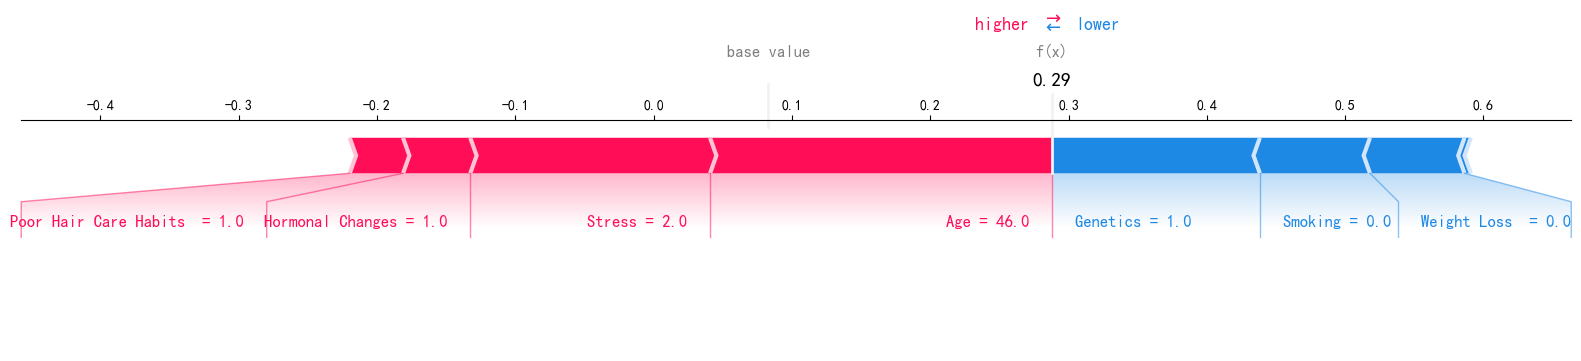

In [18]:
# 单个case的展示
shap.force_plot(explainer.expected_value, shap_values[3,:], x_model.iloc[3,:], matplotlib=True)